<h1>Imports


In [23]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')


<h1>Data preparation and division

In [20]:
# Load the data
df = pd.read_excel('jester-data-1.xls', header=None, na_values=99)

# Handle missing values by filling them with the mean of the respective joke ratings
df = df.fillna(df.mean())

# Initialize the SentenceTransformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Read jokes from files and clean the HTML tags
jokes = []
for i in range(1, 101):
    with open(os.path.join('jokes', f'init{i}.html'), 'r') as f:
        joke = f.read()
        joke = joke.split('<!--begin of joke -->')[1]
        joke = joke.split('<!--end of joke -->')[0]
        joke = re.sub('<.*?>', '', joke)
        joke = re.sub('\n', ' ', joke)
        jokes.append(joke)

# Remove the first column which indicates how many jokes each person has rated
df = df.drop(columns=[0])

# Encode jokes into their vector representations using the initialized SentenceTransformer model
joke_embeddings = model.encode(jokes)

# Create a new DataFrame with joke embeddings
df_jokes = pd.DataFrame(joke_embeddings)

# Calculate mean ratings for each joke and add them as a new column 'ratings' in df_jokes
df_jokes['ratings'] = df.mean(axis=0).values


X = df_jokes.drop('ratings', axis=1).values     #features
y = df_jokes['ratings'].values                  #labels

#training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=268555)

c:\Users\kkacp\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<h1> Basic MLP model with default config

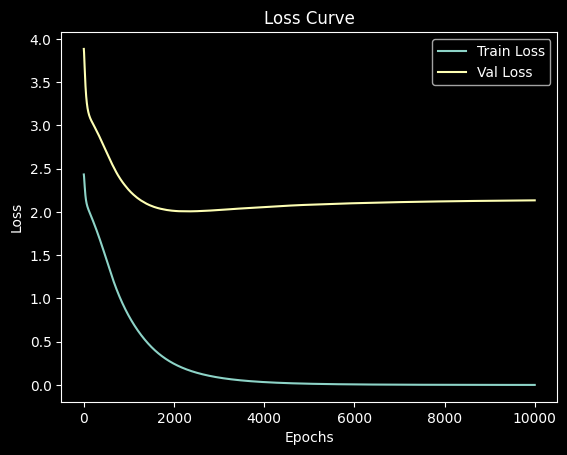

In [24]:
# Initialize MLPRegressor
mlp = MLPRegressor(
    random_state=268555,  # set seed for reproducibility
    solver='sgd',  # use stochastic gradient descent (SGD) solver for optimizing weights
    alpha=0.0,  # regularization parameter (L2 regularization)
    learning_rate='constant',  # use a constant learning rate
)

epochs = 10000  # number of epochs (iterations over the training set)
train_loss = []  # list to store training losses
val_loss = []  # list to store validation losses

# Training loop
for e in range(epochs):
    mlp.partial_fit(X_train, y_train)  # train the model using partial_fit
    train_loss.append(mean_squared_error(y_train, mlp.predict(X_train)))  # calculate training loss
    val_loss.append(mean_squared_error(y_val, mlp.predict(X_val)))  # calculate validation loss

# Plotting the loss curve
plt.plot(range(len(train_loss)), train_loss, label=f"Train Loss")
plt.plot(range(len(val_loss)), val_loss, label=f"Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

<h1>Different learning rates

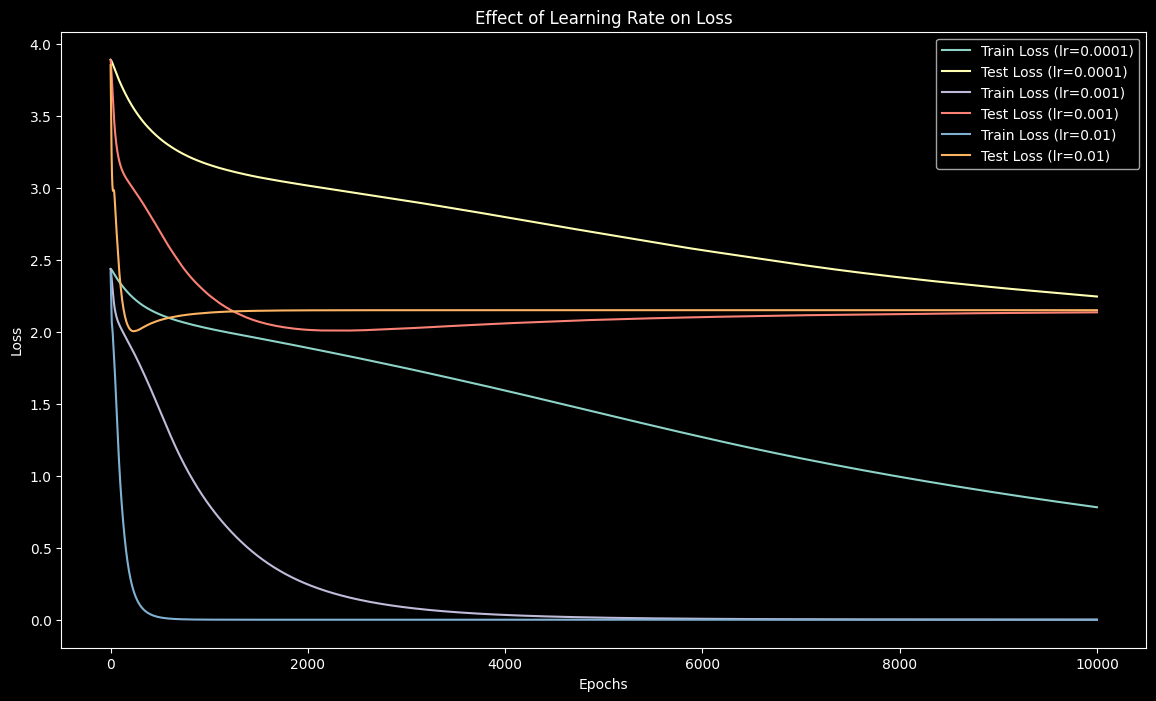

In [26]:
learning_rates = [0.0001, 0.001, 0.01]

# Dictionary to store results
results = {}

# Iterate over each learning rate
for lr in learning_rates:
    # Initialize MLPRegressor with current learning rate
    mlp = MLPRegressor(
        random_state=268555,             # set seed for reproducibility
        solver='sgd',                # use stochastic gradient descent (SGD) solver
        alpha=0.0,                   # no regularization (L2 regularization parameter)
        learning_rate='constant',    # use constant learning rate
        learning_rate_init=lr        # set initial learning rate
    )

    train_loss = []  # list to store training losses
    test_loss = []   # list to store test (validation) losses

    # Training loop for epochs
    for e in range(epochs):
        mlp.partial_fit(X_train, y_train)  # train the model on mini-batches
        train_loss.append(mean_squared_error(y_train, mlp.predict(X_train)))  # calculate training loss
        test_loss.append(mean_squared_error(y_val, mlp.predict(X_val)))  # calculate test loss (on validation set)

    # Store results for current learning rate
    results[lr] = {
        'train_loss': train_loss,
        'test_loss': test_loss
    }

# Visualize results
plt.figure(figsize=(14, 8))  # set figure size
for lr in learning_rates:
    plt.plot(range(epochs), results[lr]['train_loss'], label=f"Train Loss (lr={lr})")  # plot training loss for current lr
    plt.plot(range(epochs), results[lr]['test_loss'], label=f"Test Loss (lr={lr})")    # plot test loss for current lr

plt.xlabel('Epochs')    # set label for x-axis
plt.ylabel('Loss')      # set label for y-axis
plt.title('Effect of Learning Rate on Loss')  # set title for the plot
plt.legend()            # show legend
plt.show()              # display the plot

<h1>Different amount of neurons

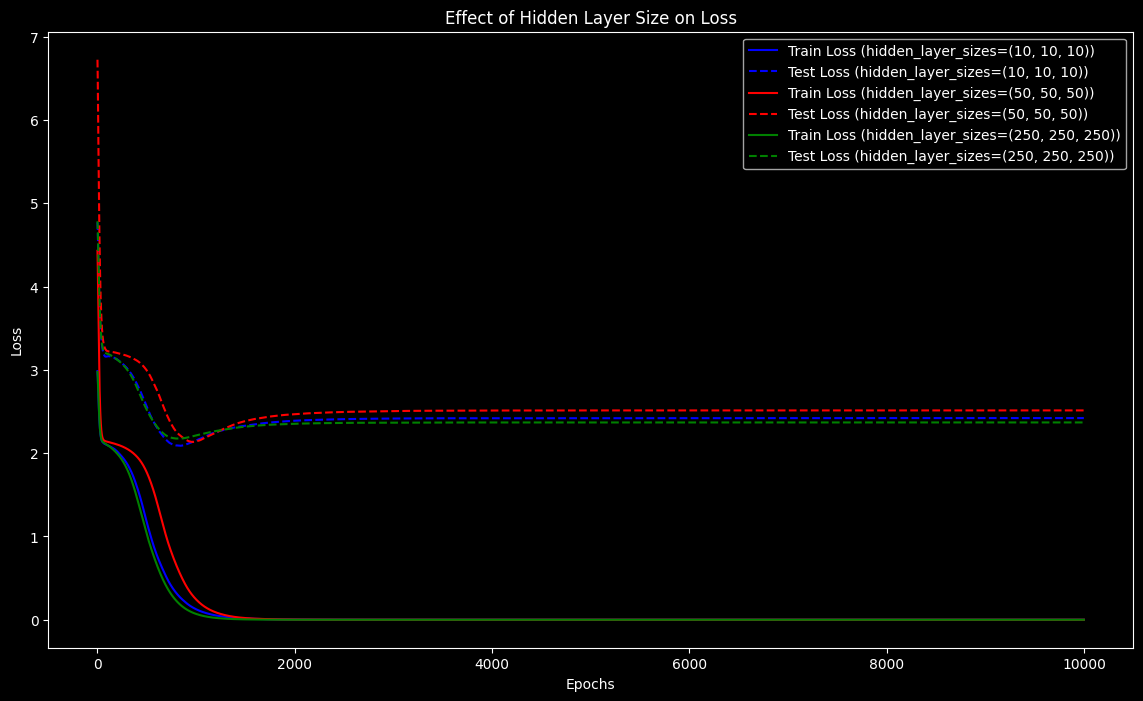

In [31]:
sizes = [(10, 10, 10), (50, 50, 50), (250, 250, 250)]

colors = ['blue', 'red', 'green']

# Dictionary to store results
results = {}

# Iterate over each hidden layer size configuration
for size in sizes:
    # Initialize MLPRegressor with current hidden layer size configuration
    mlp = MLPRegressor(
        hidden_layer_sizes=size,     # set hidden layer sizes
        random_state=268555,             # set seed for reproducibility
        solver='sgd',                # use stochastic gradient descent (SGD) solver
        alpha=0.0,                   # no regularization (L2 regularization parameter)
        learning_rate='constant',    # use constant learning rate
        learning_rate_init=0.001     # set initial learning rate
    )

    train_loss = []  # list to store training losses
    test_loss = []   # list to store test (validation) losses

    # Training loop for epochs
    for e in range(epochs):
        mlp.partial_fit(X_train, y_train)  # train the model on mini-batches
        train_loss.append(mean_squared_error(y_train, mlp.predict(X_train)))  # calculate training loss
        test_loss.append(mean_squared_error(y_val, mlp.predict(X_val)))  # calculate test loss (on validation set)

    # Store results for current hidden layer size configuration
    results[size] = {
        'train_loss': train_loss,
        'test_loss': test_loss
    }

# Visualize results
plt.figure(figsize=(14, 8))
i = 0
for size in sizes:
    plt.plot(range(epochs), results[size]['train_loss'], label=f"Train Loss (hidden_layer_sizes={size})", color=colors[i] , linestyle='-')  # plot training loss for current size
    plt.plot(range(epochs), results[size]['test_loss'], label=f"Test Loss (hidden_layer_sizes={size})", color=colors[i] , linestyle='--')
    i = i + 1    # plot test loss for current size

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Effect of Hidden Layer Size on Loss')
plt.legend()
plt.show()


<h1>Own jokes

In [52]:
own_jokes = [
"Why don't skeletons fight each other? They don't have the guts.",
"What did the grape do when it got stepped on? It let out a little wine.",
"I told my wife she should embrace her mistakes. She gave me a hug.",
"How does a penguin build its house? Igloos it together.",
"I'm reading a book on anti-gravity. It's impossible to put down!"
]
best_mlp = MLPRegressor(
        random_state=268555,
        solver='sgd',
        alpha=0.0,
        learning_rate='constant',
        hidden_layer_sizes=(50,50),
        learning_rate_init=0.001,
        max_iter=100
    )

best_mlp.fit(X_train, y_train)
best_mlp.score(X_val, y_val)

for own_joke in own_jokes:
    emb = model.encode([own_joke])
    print(best_mlp.predict(emb)[0])



c:\Users\kkacp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6990052
0.74231493
0.7626518
0.70640707
0.69762564
